In [40]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
import umap
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

from Data import Data

In [41]:
base_path = '/home/aacastro/Alejandro/DQ_ACA_2024/A/ZN_1D_imgs/orig/'
data_processor = Data(base_path)
X, Y, ass_f, ass_l = data_processor.get_data('train.npz', 'validation.npz', 'test.npz', 'assess.npz')
Y = np.argmax(Y, axis=1)

In [42]:
# OBJETIVO_VARIANZA_EXPLICADA = 0.9

X_flattened = X.reshape(4482, 264 * 18)
X_flattened= pd.DataFrame(X_flattened)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flattened)

# pca = PCA(n_components=OBJETIVO_VARIANZA_EXPLICADA)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean', random_state=42)
X_umap = umap_model.fit_transform(X_pca)

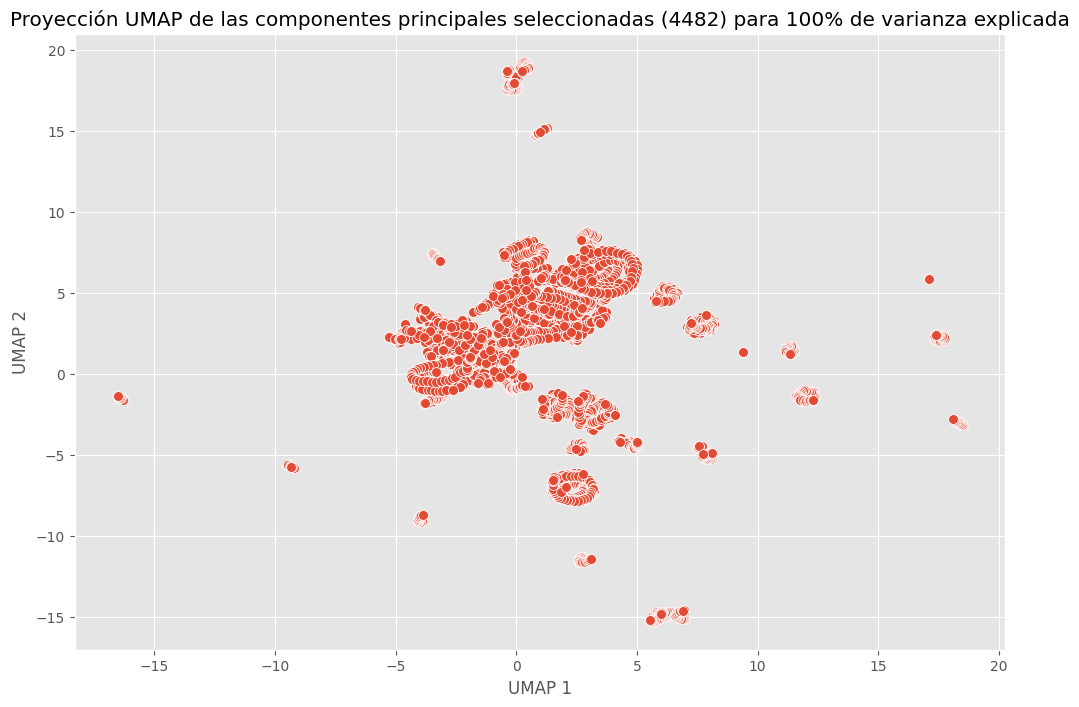

In [43]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], palette='viridis', s=50)
plt.title(f'Proyección UMAP de las componentes principales seleccionadas ({pca.n_components_}) para 100% de varianza explicada')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

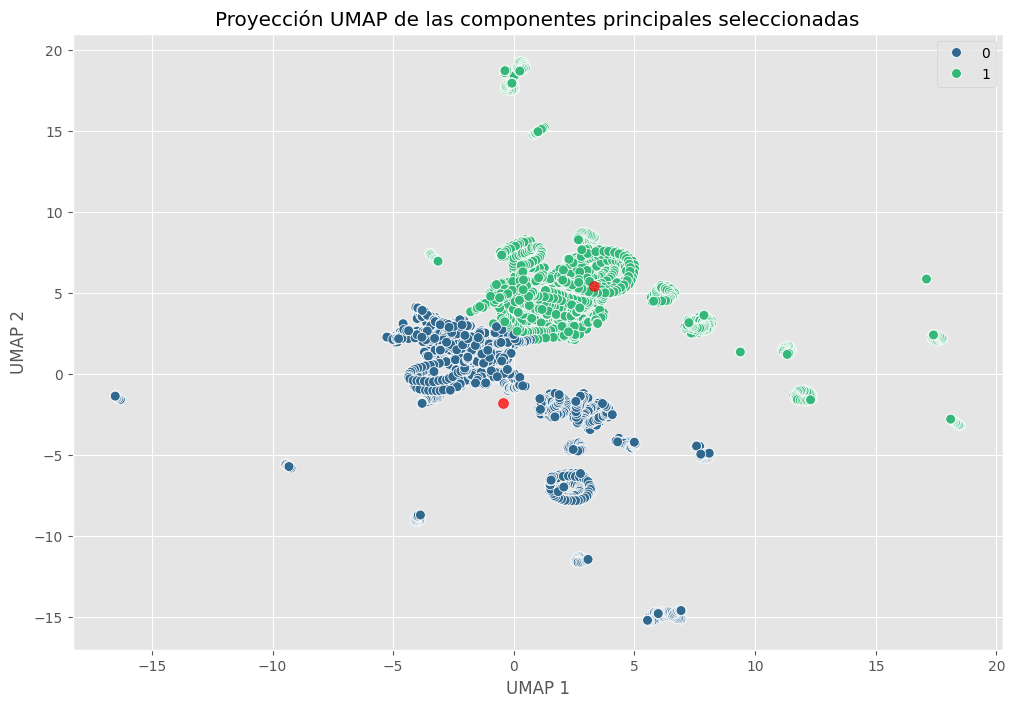

In [44]:
from sklearn.cluster import KMeans, DBSCAN

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_umap)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=clusters, palette='viridis', s=50)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='.')
plt.title('Proyección UMAP de las componentes principales seleccionadas')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# OK Cluster

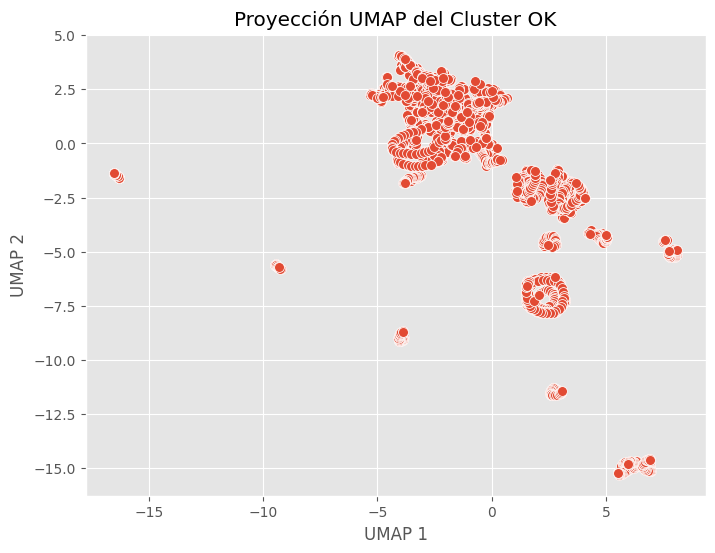

In [45]:
# Filtrar los puntos que pertenecen al cluster 0
X_cluster_0 = X_umap[clusters == 0]

# Visualizar solo los puntos del cluster 0
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_cluster_0[:, 0], y=X_cluster_0[:, 1], palette='viridis', s=50)
plt.title('Proyección UMAP del Cluster OK')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

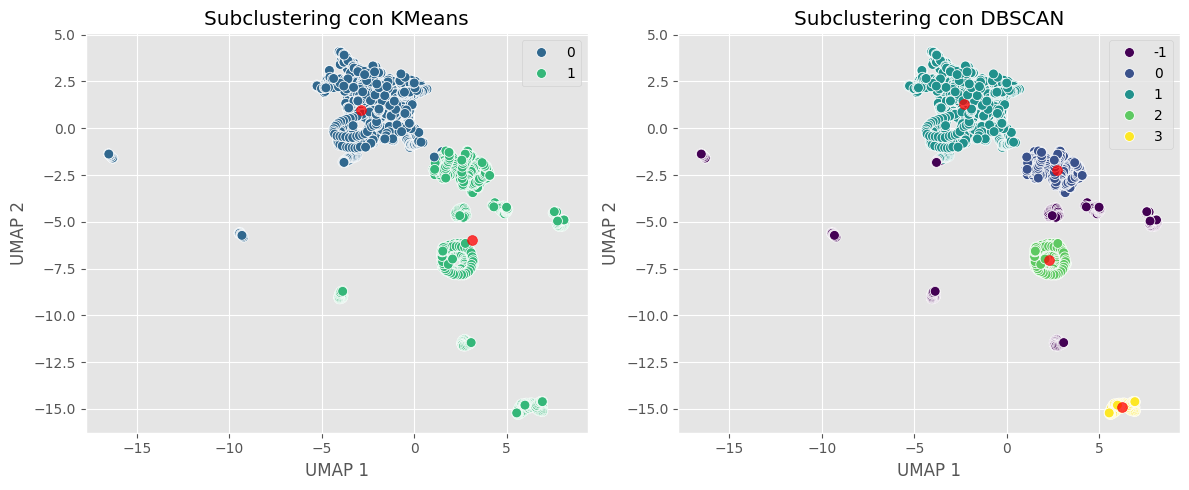

In [46]:
# Definir el número de clusters para KMeans
n_clusters_kmeans = 2  # Ajusta este valor según tus necesidades

# Crear el modelo KMeans
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_cluster_0)
centroids_kmeans = kmeans.cluster_centers_

# Crear el modelo DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=70)  # Ajusta estos parámetros según tus necesidades
clusters_dbscan = dbscan.fit_predict(X_cluster_0)

# Obtener los baricentros de los clusters de DBSCAN (no todos los clusters tienen baricentros en DBSCAN)
centroids_dbscan = []
for label in set(clusters_dbscan):
    if label != -1:  # El cluster -1 en DBSCAN representa puntos ruido
        cluster_points = X_cluster_0[clusters_dbscan == label]
        centroid = cluster_points.mean(axis=0)
        centroids_dbscan.append(centroid)
centroids_dbscan = np.array(centroids_dbscan)

# Visualizar los resultados de KMeans
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_cluster_0[:, 0], y=X_cluster_0[:, 1], hue=clusters_kmeans, palette='viridis', s=50)
plt.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], c='red', s=200, alpha=0.75, marker='.')
plt.title('Subclustering con KMeans')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Visualizar los resultados de DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_cluster_0[:, 0], y=X_cluster_0[:, 1], hue=clusters_dbscan, palette='viridis', s=50)
if len(centroids_dbscan) > 0:
    plt.scatter(centroids_dbscan[:, 0], centroids_dbscan[:, 1], c='red', s=200, alpha=0.75, marker='.')
plt.title('Subclustering con DBSCAN')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.tight_layout()
plt.show()

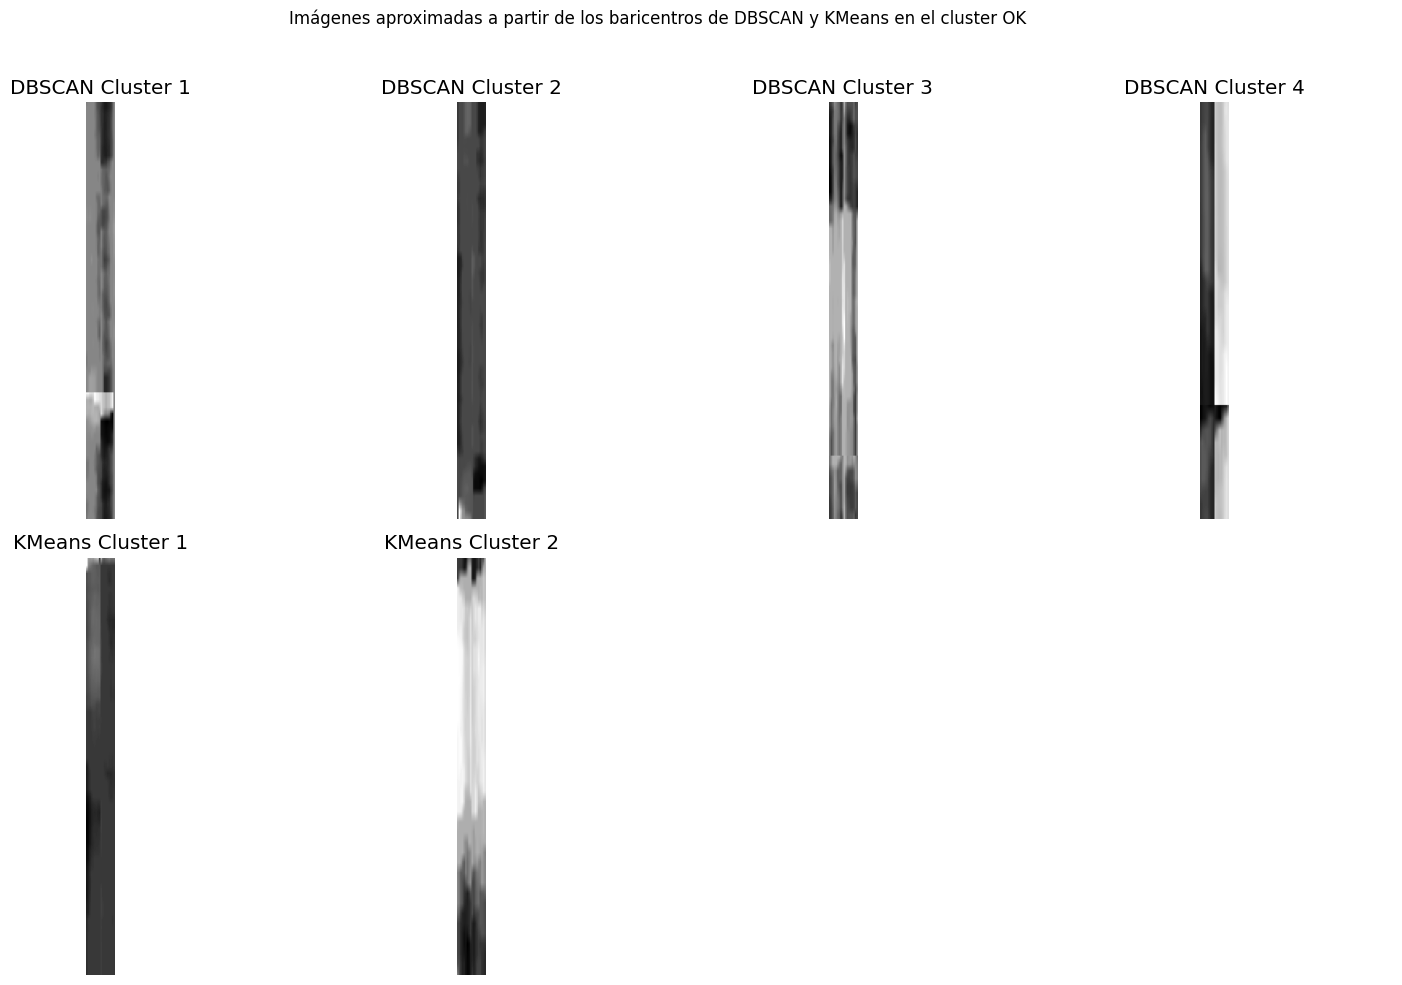

In [47]:
closest_dbscan, _ = pairwise_distances_argmin_min(centroids_dbscan, X_umap)
closest_images_dbscan = X[closest_dbscan]
closest_images_dbscan_reshaped = np.array([img.reshape((264, 18)) for img in closest_images_dbscan])

# Identificar las imágenes más cercanas a cada centroide de KMeans
closest_kmeans, _ = pairwise_distances_argmin_min(centroids_kmeans, X_umap)
closest_images_kmeans = X[closest_kmeans]
closest_images_kmeans_reshaped = np.array([img.reshape((264, 18)) for img in closest_images_kmeans])

# Determinar el número de clusters para KMeans y DBSCAN
n_clusters_dbscan = closest_images_dbscan_reshaped.shape[0]
n_clusters_kmeans = closest_images_kmeans_reshaped.shape[0]

# Determinar el número máximo de clusters para el tamaño de la gráfica
max_clusters = max(n_clusters_dbscan, n_clusters_kmeans)

# Crear la figura con dos filas
fig, axes = plt.subplots(2, max_clusters, figsize=(15, 10))

# Visualizar las imágenes de los centroides DBSCAN en la primera fila
for i in range(max_clusters):
    ax = axes[0, i]
    if i < n_clusters_dbscan:
        ax.imshow(closest_images_dbscan_reshaped[i], cmap='gray')
        ax.set_title(f'DBSCAN Cluster {i+1}')
    ax.axis('off')

# Visualizar las imágenes de los centroides KMeans en la segunda fila
for i in range(max_clusters):
    ax = axes[1, i]
    if i < n_clusters_kmeans:
        ax.imshow(closest_images_kmeans_reshaped[i], cmap='gray')
        ax.set_title(f'KMeans Cluster {i+1}')
    ax.axis('off')

plt.suptitle('Imágenes aproximadas a partir de los baricentros de DBSCAN y KMeans en el cluster OK')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# NOK Cluster

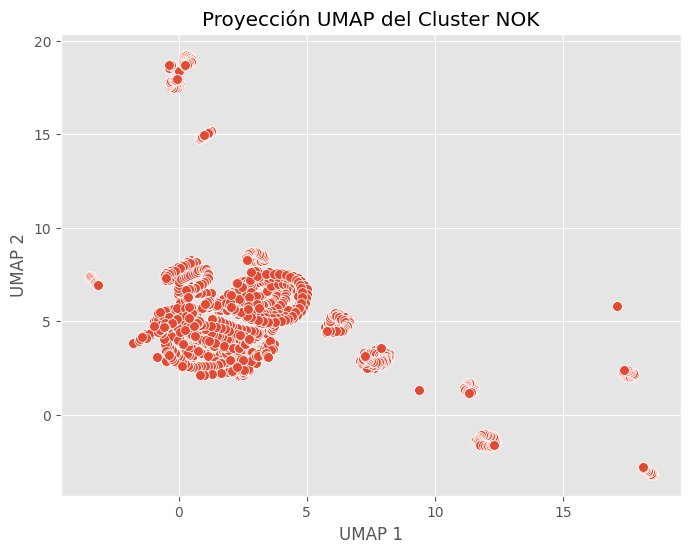

In [48]:
# Filtrar los puntos que pertenecen al cluster 0
X_cluster_1 = X_umap[clusters == 1]

# Visualizar solo los puntos del cluster 0
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_cluster_1[:, 0], y=X_cluster_1[:, 1], palette='viridis', s=50)
plt.title('Proyección UMAP del Cluster NOK')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

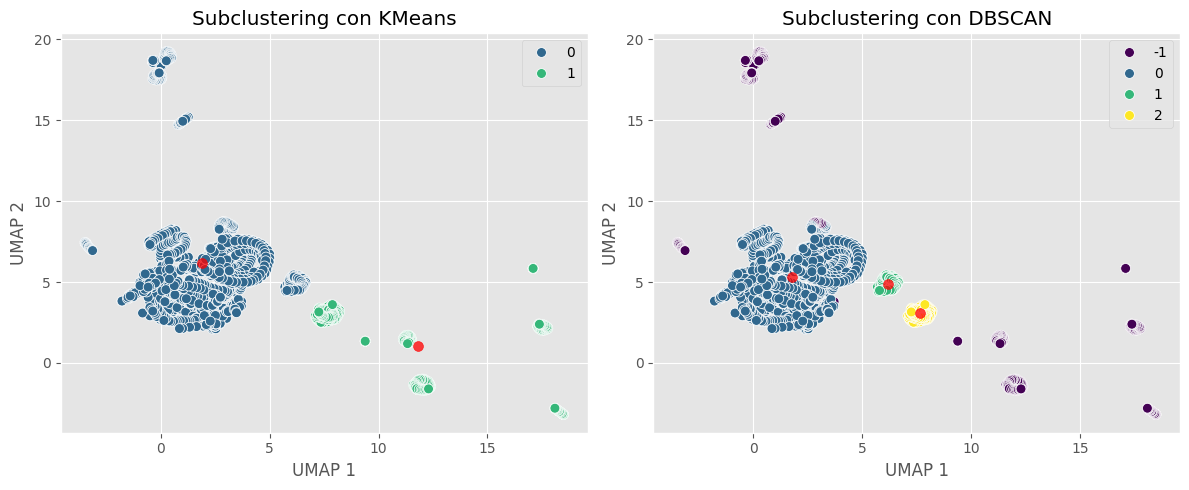

In [49]:
# Definir el número de clusters para KMeans
n_clusters_kmeans = 2  # Ajusta este valor según tus necesidades

# Crear el modelo KMeans
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_cluster_1)
centroids_kmeans = kmeans.cluster_centers_

# Crear el modelo DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=100)  # Ajusta estos parámetros según tus necesidades
clusters_dbscan = dbscan.fit_predict(X_cluster_1)

# Obtener los baricentros de los clusters de DBSCAN (no todos los clusters tienen baricentros en DBSCAN)
centroids_dbscan = []
for label in set(clusters_dbscan):
    if label != -1:  # El cluster -1 en DBSCAN representa puntos ruido
        cluster_points = X_cluster_1[clusters_dbscan == label]
        centroid = cluster_points.mean(axis=0)
        centroids_dbscan.append(centroid)
centroids_dbscan = np.array(centroids_dbscan)

# Visualizar los resultados de KMeans
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_cluster_1[:, 0], y=X_cluster_1[:, 1], hue=clusters_kmeans, palette='viridis', s=50)
plt.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], c='red', s=200, alpha=0.75, marker='.')
plt.title('Subclustering con KMeans')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Visualizar los resultados de DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_cluster_1[:, 0], y=X_cluster_1[:, 1], hue=clusters_dbscan, palette='viridis', s=50)
if len(centroids_dbscan) > 0:
    plt.scatter(centroids_dbscan[:, 0], centroids_dbscan[:, 1], c='red', s=200, alpha=0.75, marker='.')
plt.title('Subclustering con DBSCAN')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.tight_layout()
plt.show()

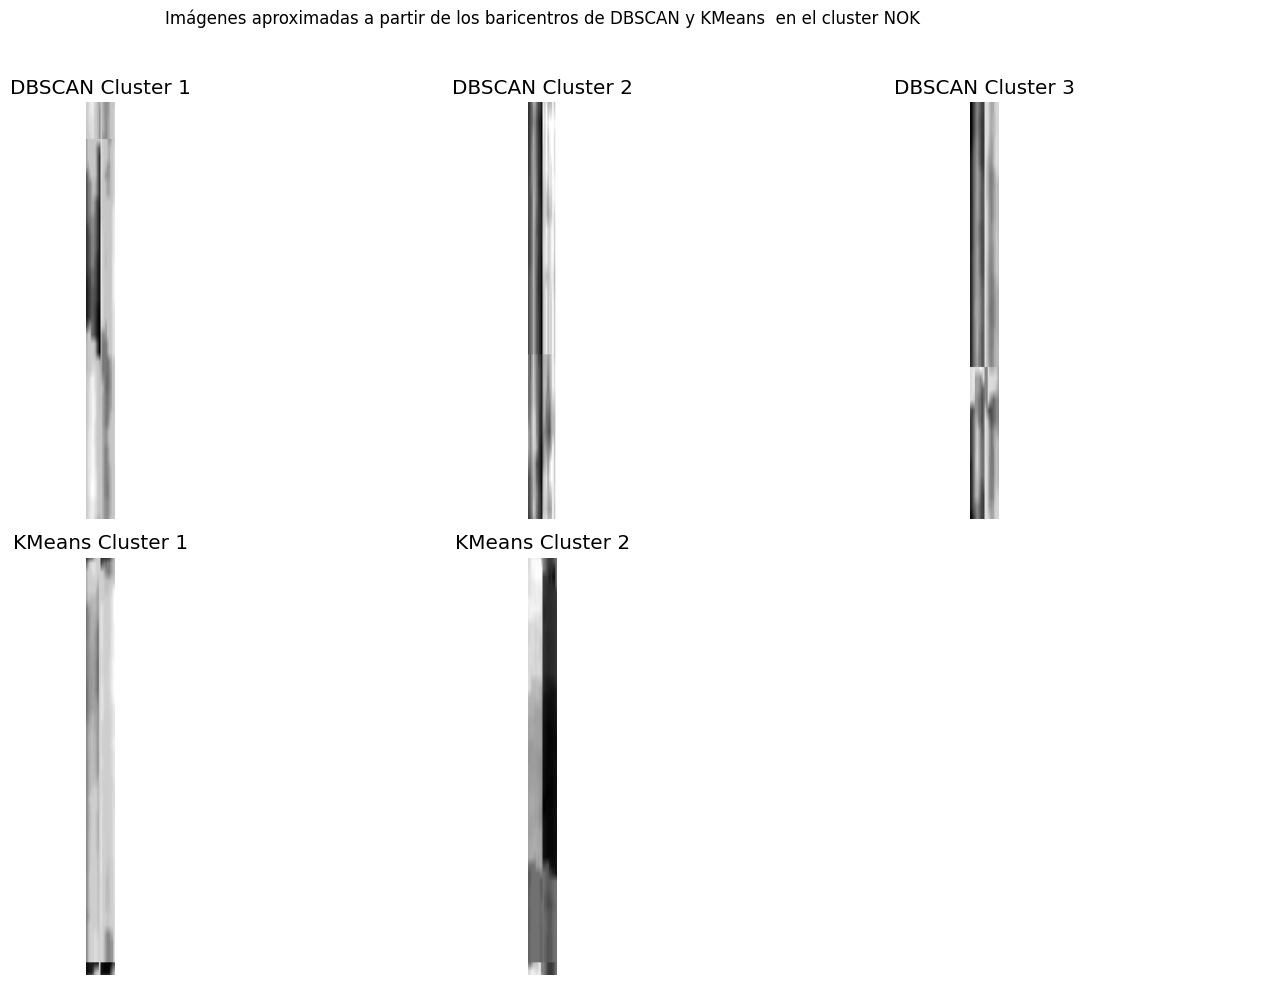

In [50]:
closest_dbscan, _ = pairwise_distances_argmin_min(centroids_dbscan, X_umap)
closest_images_dbscan = X[closest_dbscan]
closest_images_dbscan_reshaped = np.array([img.reshape((264, 18)) for img in closest_images_dbscan])

# Identificar las imágenes más cercanas a cada centroide de KMeans
closest_kmeans, _ = pairwise_distances_argmin_min(centroids_kmeans, X_umap)
closest_images_kmeans = X[closest_kmeans]
closest_images_kmeans_reshaped = np.array([img.reshape((264, 18)) for img in closest_images_kmeans])

# Determinar el número de clusters para KMeans y DBSCAN
n_clusters_dbscan = closest_images_dbscan_reshaped.shape[0]
n_clusters_kmeans = closest_images_kmeans_reshaped.shape[0]

# Determinar el número máximo de clusters para el tamaño de la gráfica
max_clusters = max(n_clusters_dbscan, n_clusters_kmeans)

# Crear la figura con dos filas
fig, axes = plt.subplots(2, max_clusters, figsize=(15, 10))

# Visualizar las imágenes de los centroides DBSCAN en la primera fila
for i in range(max_clusters):
    ax = axes[0, i]
    if i < n_clusters_dbscan:
        ax.imshow(closest_images_dbscan_reshaped[i], cmap='gray')
        ax.set_title(f'DBSCAN Cluster {i+1}')
    ax.axis('off')

# Visualizar las imágenes de los centroides KMeans en la segunda fila
for i in range(max_clusters):
    ax = axes[1, i]
    if i < n_clusters_kmeans:
        ax.imshow(closest_images_kmeans_reshaped[i], cmap='gray')
        ax.set_title(f'KMeans Cluster {i+1}')
    ax.axis('off')

plt.suptitle('Imágenes aproximadas a partir de los baricentros de DBSCAN y KMeans  en el cluster NOK')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()